# Generate Sensor Data

In this notebook, we will generate synthetic data from a model trained on our real sensor data. 

We use an open-source implementation by Gretel AI found [here](https://github.com/gretelai/gretel-synthetics) of the generative adversarial network known as DoppelGANger. For more information on DoppelGANger, see the [paper](http://arxiv.org/abs/1909.13403) and the respective GitHub [repository](https://github.com/fjxmlzn/DoppelGANger).

We are generating data based on preexisting public water pump sensor data, found on [kaggle](https://www.kaggle.com/code/xiaxiaxu/predictmachinefailureinadvance/data).

In [1]:
# first, pip installs to ensure we have the correct packages

!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git
!pip install numpy==1.20.0  # for new concatenate feature
!pip install kafka==2.0.2

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-w3s16ibv
  Running command git clone --filter=blob:none --quiet https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-w3s16ibv
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
GROUP_ID = None

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from pickle import dump, load

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

from kafka import KafkaProducer
import kafka
from time import sleep
import json
import os

print(kafka.__version__)

2.0.2


In [4]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=720,  # sequence length = 720 time units
    sample_len=20,
    batch_size=min(1000, 300),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000,
)

# initialize a model with this configuration
model = DGAN(config)

# load in our pretrained model parameters
model = model.load("models/dgan_model_5_48_sensors.pt", map_location=torch.device("cpu"))

In [5]:
# Generate synthetic data - this line generates
# 1,000 samples of 12 hour slices of data.
_, synthetic_features = model.generate_numpy(1000)

In [6]:
# four sensor columns to look at : ) 
sensor_cols = ["sensor_25", "sensor_11", "sensor_36", "sensor_34"]

# plotting function for a single slice
def plot_12hr_slice(slice, ind):
    col_indices = [23, 10, 34, 32]
    for i in range(4):
        column = col_indices[i]
        label_i = sensor_cols[i]
        plt.plot(slice[:, column], label=label_i)
    ax = plt.gca()
    ax.title.set_text("Slice " + str(ind))
    plt.legend(prop={"size": 7})

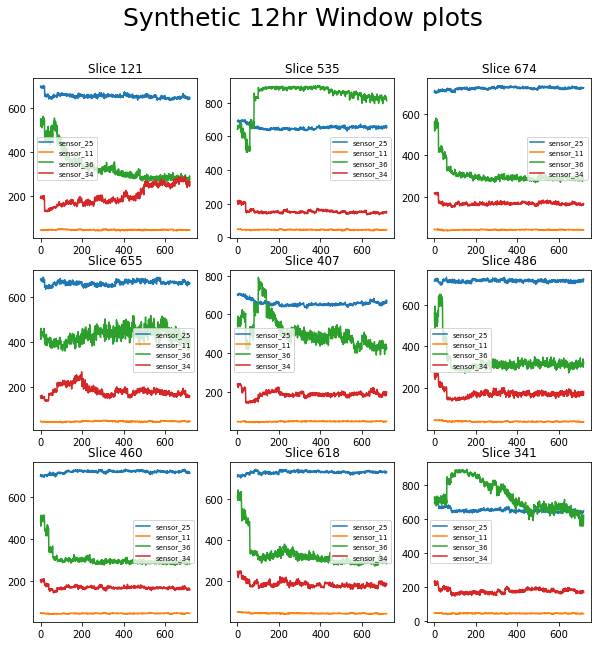

In [7]:
# plot 9 random synthetic windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Synthetic 12hr Window plots", fontsize=25, fontweight="roman")

for i in range(9):
    figure.add_subplot(3, 3, i + 1)
    index = np.random.choice(1000)  # choose a random index from our 1,000 samples
    sl = synthetic_features[index]  # select the slice from that index
    plot_12hr_slice(sl, index)

plt.show()

### Selecting your slice.

- Now that we have generated 1,000 slices of random data, it's time for you to choose a single slice.

- In the plot above, you can see 9 different plots of slices of data. Above each plot is the slice number. 

- If you don't like the look of any of the plots in this figure, you can re-run the cell above to see another set of 9 random slices.

- Once you see a slice that you like, **enter the corresponding slice number into the cell below where it's marked.**

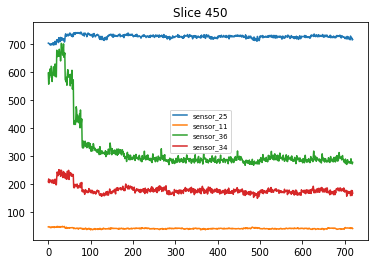

In [8]:
# enter your slice number below
my_slice_num = 450

my_slice = synthetic_features[my_slice_num]

# let's plot that slice to make sure we've got it.
plot_12hr_slice(my_slice, my_slice_num)
plt.show()

### Streaming our sensor data.

- We've got our slice of synthetic sensor data selected now.

- It's time for us to stream our data 'from the sensor' to our model and our database. 

- We'll do so using [Apache Kafka](https://kafka.apache.org/) streaming, an open-source distributed event streaming platform. 


First we need to add some fake timestamps to our data - let's do that by converting our data slice to a pandas dataframe with a column of timestamps and then convert it back to numpy so we can easily work with it as an array.

In [9]:
# create initial time
time_0 = np.datetime64('2022-09-01 00:00:00')
timestamps_array = np.array(time_0)

In [10]:
# add 1 minute to initial time array, 719 times
for i in range(1,720):
    new_time = [time_0 + np.timedelta64(i, 'm')]
    timestamps_array = np.append(timestamps_array, new_time)

In [11]:
print(timestamps_array.shape)  # how many timestamps do we have
print(timestamps_array[5:10])  # print 5 example timestamps
timestamps_array = np.datetime_as_string(timestamps_array, unit='m') # convert to string
print(timestamps_array[5:10]) 

(720,)
['2022-09-01T00:05:00' '2022-09-01T00:06:00' '2022-09-01T00:07:00'
 '2022-09-01T00:08:00' '2022-09-01T00:09:00']
['2022-09-01T00:05' '2022-09-01T00:06' '2022-09-01T00:07'
 '2022-09-01T00:08' '2022-09-01T00:09']


In [12]:
# add the column to the slice we have
timestamps_array = np.expand_dims(timestamps_array,1)
print(timestamps_array.shape)
print(my_slice.shape)
my_slice = np.concatenate((timestamps_array, my_slice), axis=1, dtype='object')
my_slice.shape

(720, 1)
(720, 49)


(720, 50)

Great, we've got our slice setup with some simulated timestamps. Now it's time to start streaming our data.

First let's define how we're going to connect to our kafka cluster.

In [13]:
KAFKA_BOOTSTRAP_SERVER = 'kafka-cluster-kafka-bootstrap.kafka-anomaly.svc.cluster.local'

KAFKA_SASL_MECHANISM = os.environ.get("KAFKA_SASL_MECHANISM", "PLAIN")
KAFKA_SECURITY_PROTOCOL = "PLAINTEXT"

# SASL username or client ID loaded from the environment variable
KAFKA_USERNAME = os.environ.get("KAFKA_USERNAME")

# SASL password or client secret loaded from the environment variable
KAFKA_PASSWORD = os.environ.get("KAFKA_PASSWORD")

# Name of the topic for the producer to send messages.
# Consumers will listen to this topic for events.
KAFKA_TOPIC = os.environ.get("KAFKA_TOPIC") or "sensor-data"

Now, it's time to stream the data. Our function here will connect to the kafka cluster, initialize a KafkaProducer object, and then start streaming messages to our topic.

In [14]:
def produce_data(sensor_slice):
    # create the producer
    producer = KafkaProducer(
        bootstrap_servers=[KAFKA_BOOTSTRAP_SERVER],
        security_protocol=KAFKA_SECURITY_PROTOCOL,
        sasl_plain_username=KAFKA_USERNAME,
        sasl_plain_password=KAFKA_PASSWORD,
        api_version_auto_timeout_ms=30000,
        max_block_ms=900000,
        request_timeout_ms=450000,
        acks="all",
        key_serializer=str.encode,
    )

    # sending our data 10 rows per second
    for row_index in range(0, 720, 10):
        # select our 10 rows
        ten_rows = sensor_slice[row_index : row_index + 10, :]
        # wait a second
        sleep(1)
        for i in range(10):
            one_row = ten_rows[i].tolist()
            jsonpayload = json.dumps(
                {
                    "timestamp": one_row[0],
                    "sensor_data": one_row[1:-1],
                    "machine_status": one_row[-1],
                }
            )
            producer.send(KAFKA_TOPIC, jsonpayload.encode("utf-8"), key=str(GROUP_ID))
    producer.flush()  # Important, especially if message size is small

In [15]:
produce_data(my_slice)

2022-08-24 15:51:13,521 : MainThread : INFO : <BrokerConnection node_id=bootstrap-0 host=kafka-cluster-kafka-bootstrap.kafka-anomaly.svc.cluster.local:9092 <connecting> [IPv4 ('172.30.229.157', 9092)]>: connecting to kafka-cluster-kafka-bootstrap.kafka-anomaly.svc.cluster.local:9092 [('172.30.229.157', 9092) IPv4]
2022-08-24 15:51:13,521 : MainThread : INFO : Probing node bootstrap-0 broker version
2022-08-24 15:51:13,526 : MainThread : INFO : <BrokerConnection node_id=bootstrap-0 host=kafka-cluster-kafka-bootstrap.kafka-anomaly.svc.cluster.local:9092 <connecting> [IPv4 ('172.30.229.157', 9092)]>: Connection complete.
2022-08-24 15:51:13,630 : MainThread : INFO : Broker version identified as 2.5.0
2022-08-24 15:51:13,630 : MainThread : INFO : Set configuration api_version=(2, 5, 0) to skip auto check_version requests on startup
2022-08-24 15:51:14,638 : kafka-python-producer-1-network-thread : INFO : <BrokerConnection node_id=2 host=kafka-cluster-kafka-2.kafka-cluster-kafka-brokers.kaf